# **Homework 5 - USA Airport Flight Analysis**

## Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## 1. Flight Network Analysis (Q1)

### Basic analysis

In [2]:
# Loading dataset
df = pd.read_csv("Airports2.csv")
df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3565050 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 435.2+ MB


In [15]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.558466e+06,3.558466e+06,3.558555e+06,3.558555e+06
mean,2.720375e+03,4.095619e+03,3.760448e+01,6.954350e+02,5.864580e+06,5.889934e+06,3.772410e+01,-9.176235e+01,3.771923e+01,-9.174049e+01
std,4.363210e+03,6.221537e+03,4.977841e+01,5.995712e+02,7.833335e+06,7.884462e+06,5.720273e+00,1.643580e+01,5.702781e+00,1.638317e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.150000e+02,1.730000e+02,2.000000e+00,2.740000e+02,1.035566e+06,1.029829e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.161000e+03,2.074000e+03,2.500000e+01,5.180000e+02,2.404337e+06,2.404337e+06,3.885210e+01,-8.741280e+01,3.885210e+01,-8.775240e+01
75%,3.541000e+03,5.442000e+03,5.500000e+01,9.260000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [16]:
df.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6584
Org_airport_long          6584
Dest_airport_lat          6495
Dest_airport_long         6495
dtype: int64

In [5]:
df.duplicated().sum()

41753

In [6]:
df = df.drop_duplicates()

### Required analysis

In [3]:
flight_network = nx.DiGraph()
for _, row in df.iterrows():
    flight_network.add_edge(row['Origin_airport'], row['Destination_airport'])

In [30]:
def analyse_graph_features(flight_network):
    # Calculating number of nodes and edges
    nodes = set()
    num_edges = 0
    for edge in flight_network.edges:
        num_edges += 1
        nodes.add(edge[0])
        nodes.add(edge[1])
    num_nodes = len(nodes)

    # Calculating density of graph 
    density = 2 * num_edges / (num_nodes * (num_nodes - 1))

    # Calculate in-degree and out-degree for each airport
    in_degree = {}
    out_degree = {}
    for node in flight_network.nodes:
        in_degree[node] = 0
        out_degree[node] = 0
    
    for edge in flight_network.edges:
        scr, dst = edge
        in_degree[dst] += 1
        out_degree[scr] += 1

    # For visualisation we extract the values
    in_degree_vals = list(in_degree.values())
    out_degree_vals = list(out_degree.values())

    # Plotting
    plt.figure(figsize=(12, 6))

    # In
    plt.subplot(1, 2, 1)
    plt.hist(in_degree_vals, bins=30, color='skyblue', edgecolor='black')
    plt.title('In-Degree Distribution')
    plt.xlabel('In-Degree')
    plt.ylabel('Frequency')

    # Out
    plt.subplot(1, 2, 2)
    plt.hist(out_degree_vals, bins=30, color='orange', edgecolor='black')
    plt.title('Out-Degree Distribution')
    plt.xlabel('Out-Degree')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Combine degrees to compute hubs
    total_degree = {}
    for node in flight_network.nodes:
        total_degree[node] = in_degree[node] + out_degree[node]
    
    # Find 90th percentile thresholds
    in_degree_90th = np.percentile(in_degree_vals, 90)
    out_degree_90th = np.percentile(out_degree_vals, 90)
    total_degree_90th = np.percentile(list(total_degree.values()), 90)

    # Identify hubs
    in_hubs = [node for node, degree in in_degree.items() if degree > in_degree_90th]
    out_hubs = [node for node, degree in out_degree.items() if degree > out_degree_90th]
    total_hubs = [node for node, degree in total_degree.items() if degree > total_degree_90th]

    # Determine if graph is sparse using Rule of Thumb
    # 6. Determine if the graph is sparse or dense
    graph_type = "Dense" if density >= 0.1 else "Sparse"

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "density": density,
        "in_degree": in_degree,
        "out_degree": out_degree,
        "total_degree": total_degree,
        "in_hubs": in_hubs,
        "out_hubs": out_hubs,
        "total_hubs": total_hubs,
        "graph_type": graph_type
    }     


In [31]:
def summarize_graph_features(flight_network):
    analysis_res = analyse_graph_features(flight_network)
    #num_nodes, num_edges, density, in_degree, out_degree, total_degree, in_hubs, out_hubs, total_hubs, graph_type  = analyse_graph_features(flight_network)

    # Extract results for easier access
    num_nodes = analysis_res["num_nodes"]
    num_edges = analysis_res["num_edges"]
    density = analysis_res["density"]
    in_hubs = analysis_res["in_hubs"]
    out_hubs = analysis_res["out_hubs"]
    total_hubs = analysis_res["total_hubs"]
    in_degree = analysis_res["in_degree"]
    out_degree = analysis_res["out_degree"]
    total_degree = analysis_res["total_degree"]
    graph_type = analysis_res["graph_type"]


    # Create a df for hubs
    hubs_data = {
        'Node': list(set(in_hubs + out_hubs + total_hubs)),
        'In-Degree': [in_degree[node] for node in set(in_hubs + out_hubs + total_hubs)],
        'Out-Degree': [out_degree[node] for node in set(in_hubs + out_hubs + total_hubs)],
        'Total Degree': [total_degree[node] for node in set(in_hubs + out_hubs + total_hubs)],
    }
    hubs_df = pd.DataFrame(hubs_data)

    # Create a summary report
    print("Graph Summary Report:")
    print(f"Number of airports (nodes): {num_nodes}")
    print(f"Number of flights (edges): {num_edges}")
    print(f"Graph Density: {density:.4f}")
    print(f"Graph Type: {graph_type}")

    print("\nIdentified Hubs (Airports with high degree):")
    print(hubs_data)

    # Plot degree distributions again for the summary
    plt.figure(figsize=(12, 6))

    # In-degree plot
    plt.subplot(1, 2, 1)
    plt.hist(list(in_degree.values()), bins=30, color='skyblue', edgecolor='black')
    plt.title("In-degree Distribution")
    plt.xlabel("In-degree")
    plt.ylabel("Frequency")

    # Out-degree plot
    plt.subplot(1, 2, 2)
    plt.hist(list(out_degree.values()), bins=30, color='salmon', edgecolor='black')
    plt.title("Out-degree Distribution")
    plt.xlabel("Out-degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


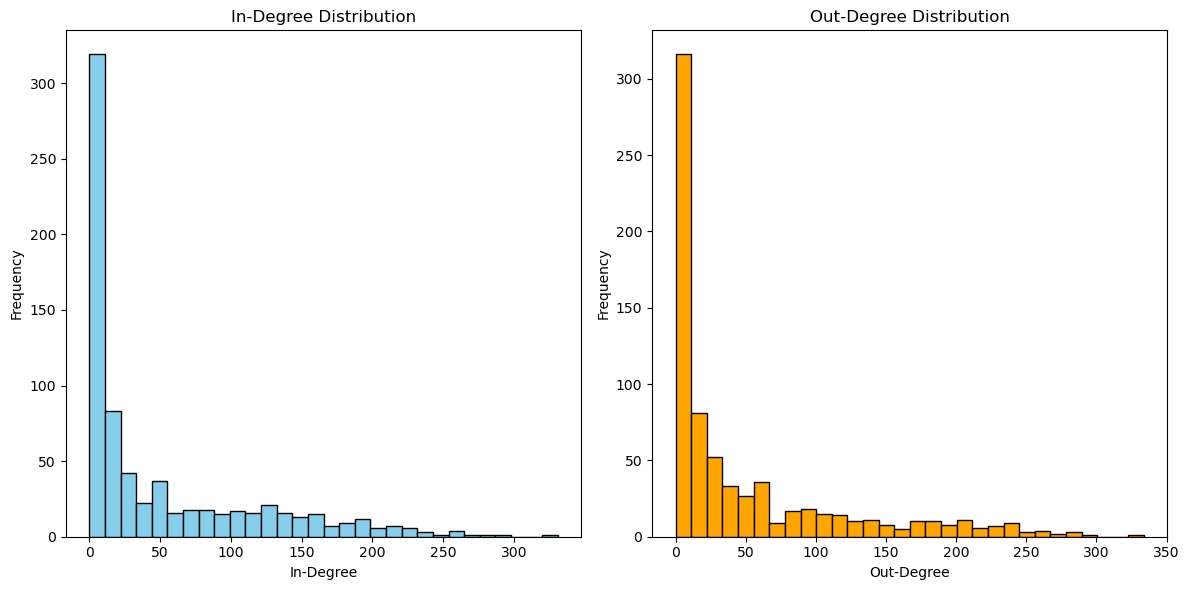

Graph Summary Report:
Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.1391
Graph Type: Dense

Identified Hubs (Airports with high degree):
{'Node': ['MSY', 'DAY', 'BHM', 'PIA', 'LRD', 'CLE', 'IAH', 'MEM', 'SBN', 'BOS', 'STL', 'CLT', 'COS', 'MDW', 'EWR', 'PDX', 'TOL', 'MIA', 'IND', 'IAD', 'DSM', 'DFW', 'MCO', 'MKE', 'GRR', 'TPA', 'ICT', 'ORD', 'CAE', 'YIP', 'ABQ', 'SAN', 'SAT', 'SLC', 'PIT', 'BWI', 'SYR', 'MCI', 'CVG', 'LAN', 'OMA', 'TUS', 'JFK', 'MSP', 'BDL', 'SFO', 'LIT', 'RFD', 'JAX', 'AUS', 'HOU', 'SEA', 'DAL', 'DTW', 'RDU', 'CHA', 'PHX', 'LGA', 'GSP', 'MSN', 'TUL', 'ATL', 'LAS', 'OAK', 'RNO', 'FWA', 'OKC', 'FLL', 'LEX', 'SHV', 'LAX', 'TYS', 'CMH', 'PHL', 'GSO', 'BUF', 'ELP', 'BNA'], 'In-Degree': [191, 186, 180, 164, 183, 211, 217, 277, 161, 167, 257, 191, 176, 202, 195, 158, 172, 236, 255, 230, 169, 251, 195, 222, 152, 161, 189, 240, 172, 331, 181, 143, 190, 219, 209, 210, 160, 272, 203, 164, 186, 212, 194, 291, 162, 164, 212, 218, 146, 178, 164, 1

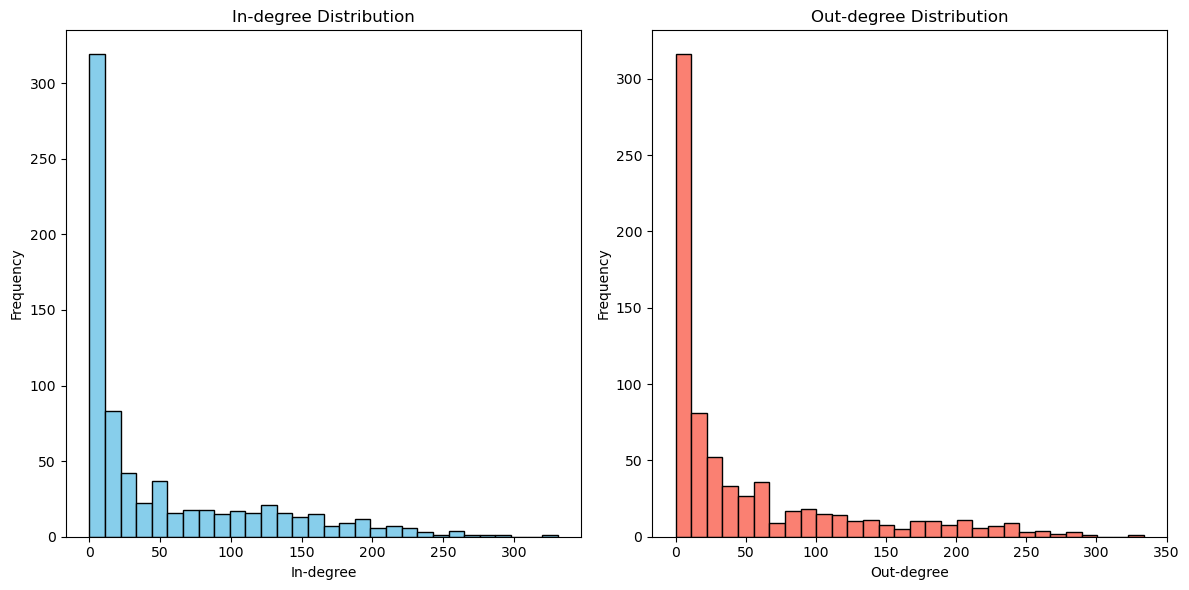

In [32]:
summarize_graph_features(flight_network)